<a href="https://colab.research.google.com/github/MasterDiaz410/ProyectoSL1/blob/master/Proyecto_SL1_Parte1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statistical Learning I
 **Proyecto final de clase**


---



**Descripción**
El proyecto consiste en hacer clasificación binaria  para determinar si una persona sobrevive(y=1) o no (y=0) del hundimiento del Titanic.

Bueno... empecemos con la resolución del problema. Para ello cargamos todos los paquetes que necesitamos en el proyecto, acá ire pegando cada vez que necesite una nueva librera su código y explicación correspondiente.

In [1]:
import numpy as np
import pandas as pd
import math

from joblib import dump
from scipy.stats import norm
from datetime import datetime

import tensorflow as tf
from tensorflow import keras

%matplotlib inline
from matplotlib import pyplot as plt

import os
from scipy.stats import norm
from datetime import datetime

from sklearn import tree
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import PolynomialFeatures


Nos quitamos algunos problemas de compatibilidad con tensorflow

In [2]:
if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


# Parte 1

Los datos se encuentran en el archivo denominado data_titanic_proyecto.csv el cual lo tengo alojado en la ruta de colab de google en el drive, procedemos a cargarlos para iniciar con el análisis exploratorio de los datos.

In [3]:
#montamos el contenido del drive
from google.colab import drive 
drive.mount('/content/gdrive')

# Cargando dataset de vinos
dfTitanic = pd.read_csv('gdrive/My Drive/Colab Notebooks/data_titanic_proyecto.csv')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Veamos que contiene nuestro dataframe ...

In [4]:
# dimensiones del data frame
dfTitanic.shape

(891, 12)

In [5]:
dfTitanic.head()

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
0,1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Lower,M,N
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Upper,F,Y
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Lower,F,Y
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Upper,F,Y
4,5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Lower,M,N


Vemos que la data posee 891 registros con 12 columnas, además podemos verificar que existen datos NaN, de igual forma variables categóricas commo Ticket, passenger_class, vemos que algunas pueden ser factores. por lo que inicialmente con muy pocos datos vemos que nuestra data no se encuentra 100% limpia. Además que la variable que vamos a tratar predecir es ***passenger_survived***

Conozcamos un poco más nuestros datos, veamos algunos datos estadísticos básicos que lo representen.

In [6]:
dfTitanic.describe()

,PassengerId,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,29.699118,0.523008,0.381594,32.204208
std,257.353842,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,38.000000,1.000000,0.000000,31.000000
max,891.000000,80.000000,8.000000,6.000000,512.329200


Vaya que resulta interesante, con la data sin ninguna transformación vemos los siguientes datos relevantes. 

*   El promedio de edad de las personas a bordo del Titanic es aproximadamente 30 años.
*   Las tarifas de los tickets de los pasajeros se encuentra hasta un maximo de 512 en la moneda del dataset.


Bueno luego de un análisis previo, con los datos procedamos a normalizar y llevar a cabo alguna limpieza sobre nuestros datos.

Eliminemos los NaN a un valor comprensible, por facilidad le seteamos un 0

In [7]:
dfTitanic = dfTitanic.fillna(0)

#### Selección de Variables

Posibles variables predictoras
- Age
- Fare
- passenger_class
- passenger_sex

Variable a predecir

- passenger_survived

Ahora cambiemos nuestras variables categóricas para luego analizar si le aportan algo a nuestro modelo.

In [8]:
dfTitanic['passenger_sex_codes'] = dfTitanic['passenger_sex'].astype('category').cat.codes
dfTitanic['passenger_survived_category'] = dfTitanic['passenger_survived'].astype('category').cat.codes
dfTitanic['passenger_class_codes'] = dfTitanic['passenger_class'].astype('category').cat.codes

Veamos como quedaron nuestras variables

In [9]:
dfTitanic.head()

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived,passenger_sex_codes,passenger_survived_category,passenger_class_codes
0,1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,0,S,Lower,M,N,1,0,0
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Upper,F,Y,0,1,2
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,0,S,Lower,F,Y,0,1,0
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Upper,F,Y,0,1,2
4,5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,0,S,Lower,M,N,1,0,0


Ahora si veamos los datos estadisticos, con la información ya lista para trabajar

In [10]:
dfTitanic.describe()

,PassengerId,Age,SibSp,Parch,Fare,passenger_sex_codes,passenger_survived_category,passenger_class_codes
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,23.799293,0.523008,0.381594,32.204208,0.647587,0.383838,0.691358
std,257.353842,17.596074,1.102743,0.806057,49.693429,0.477990,0.486592,0.836071
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,6.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000
50%,446.000000,24.000000,0.000000,0.000000,14.454200,1.000000,0.000000,0.000000
75%,668.500000,35.000000,1.000000,0.000000,31.000000,1.000000,1.000000,1.000000
max,891.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,2.000000


A veces es muy dificil poder visualizar la información, cuando solamente son números lo que se nos presentan. Veamos de forma visual la información para ver que más podemos detectar de esta forma.

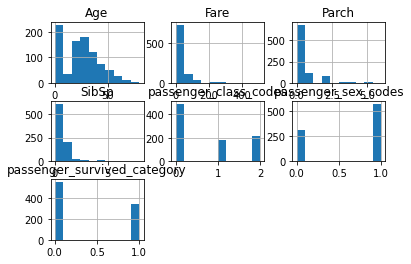

In [11]:
# Visualizamos rápidamente las caraterísticas de entrada
dfTitanic.drop(['PassengerId','passenger_class', 'passenger_survived', 'passenger_sex'],1).hist()
plt.show()


Veamos la correlacion de la informacion respecto a la variable que deseamos predecir

In [12]:
dfTitanic[dfTitanic.columns[1:]].corr()['passenger_survived_category'][:]

Age                            0.010539
SibSp                         -0.035322
Parch                          0.081629
Fare                           0.257307
passenger_sex_codes           -0.543351
passenger_survived_category    1.000000
passenger_class_codes          0.338481
Name: passenger_survived_category, dtype: float64

Con los datos anteriores podemos concluir la siguiente información las features que tienen más correlación postiva con nuestra variable a predecir, donde respecto a las demás features, **Fare** y **Passenger_class** tienen valores no tan grandes cercanos a uno, pero como lo indico anteriormente podrian apoyar bastante en la definición de la variable y a predecir. Ahora bien vemos un comportamiento de *correlacion negativa* con la variable **passenger_sex_cat**.

Vamos a proceder a eliminar las features que no nos aportan mayor información a nuestra variable a predecir, además vamos a almacenar la información en los dataframes típicos X y Y simplemente para que sea más facil identificarlas posteriormente.

#### Depuración de features

Se eliminan aquellas características que son identificadores, nombres o etiquetas.

In [13]:
X=dfTitanic.drop(['passenger_survived_category','PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked', 'passenger_class', 'passenger_sex', 'passenger_survived'], axis=1)
Y=dfTitanic['passenger_survived_category']

Veamos como luce ahora nuestra data

In [14]:
# Features
X.head()

,Age,SibSp,Parch,Fare,passenger_sex_codes,passenger_class_codes
0,22.0,1,0,7.2500,1,0
1,38.0,1,0,71.2833,0,2
2,26.0,0,0,7.9250,0,0
3,35.0,1,0,53.1000,0,2
4,35.0,0,0,8.0500,1,0


In [15]:
# Variable a predecir, label
Y.head()

0    0
1    1
2    1
3    1
4    0
Name: passenger_survived_category, dtype: int8

Ahora ya es un poco mas visible de acuerdo al cuadro de correlaciones y visualizando un poco los datos de forma mas limpia respecto a que features podemos usar para iniciar a armar nuestro modelo.

*   Fare (correlacion positiva)
*   passenger_class_cat (correlacion positiva)
*   passenger_sex_cat (correlacion negativa)


De igual forma, veamos que nos dice una herramienta para seleccion de features

In [16]:
bestFeature = SelectKBest(k=3)
bestFeature.fit_transform(X, Y)
selectedFeature = bestFeature.get_support(indices=True)
print(X.columns[selectedFeature])

Index(['Fare', 'passenger_sex_codes', 'passenger_class_codes'], dtype='object')


Por lo que por orden de prioridad corresponden a la seleccion realizada anteriormente


*   passenger_sex_cat
*   passenger_class_cat
*   Fare

Por lo que ya con toda seguridad podemos tomar estas tres features, para iniciar el proceso de entrenamiento de nuestro modelo

Ya como ultimo paso, limpiamos nuestras features de aquellas que no vamos a utilizar para predecir.

In [17]:
used_features = X.columns[selectedFeature]
X = X.drop(['Parch', 'Age', 'SibSp'], axis=1)

Veamos como luce el dataframe de features nuevamente

In [18]:
X.head()

,Fare,passenger_sex_codes,passenger_class_codes
0,7.2500,1,0
1,71.2833,0,2
2,7.9250,0,0
3,53.1000,0,2
4,8.0500,1,0


# Iniciando con el entrenamiento
Como ya es costumbre procedemos a dividir nuestra informacion en el conocido 80 - 20, donde el 80% de datos los vamos a utilizar para entrenar nuestro modelo

#### División de datos para entreno, validación y prueba

In [19]:
xTrainingData, xTestingData, yTrainingData, yTestingData = train_test_split(X, Y, test_size=0.2)
xTrainingData, x_validate, yTrainingData, yValidateData = train_test_split(xTrainingData, yTrainingData, test_size=0.3)

# Funciones comunes y generales para la definicion del proyecto

In [20]:
#crea el CSV para el log
logFile = {'string_config': [], 'accuracy': [], 'error': [], 'precision': [], 'recall': [], 'f1': []}
df = pd.DataFrame(logFile, columns= ['string_config', 'accuracy', 'error', 'precision', 'recall', 'f1'])
df.to_csv('gdrive/My Drive/Colab Notebooks/proyecto1_modelos/logFile.csv', index = False, header=True)

In [21]:
# rescribe el log csv
def set_record(string_config, metrics):
    logFile = {'string_config': [string_config], 
                'accuracy': [metrics[0]],
                'error': [metrics[1]],
                'precision': [metrics[2]],
                'recall': [metrics[3]],
                'f1': [metrics[4]]}
    logFile = pd.DataFrame(logFile, columns= ['string_config', 'accuracy', 'error', 'precision', 'recall', 'f1'])
    logFile.to_csv('logFile.csv', mode='a', index = False, header=False)

In [22]:
# cadena que concatena las metricas
def getGlobalString(str_model, mtr):
    return "Model: "+str_model+" \n Accuracy: " + get_percent(mtr[0])+" \n Error: "+get_percent(mtr[1])+" \n Precision: "+get_percent(mtr[2])+" \n Recall: "+get_percent(mtr[3])+" \n F1: "+get_percent(mtr[4])

In [23]:
# genera una representacion de porcentaje
def get_percent(number):
    return str(round((number*100),2))+"%"

In [24]:
def getGlobalMetrics(y_true, y_predict):

    accuracy = accuracy_score(y_true, y_predict)
    error = mean_squared_error(y_true, y_predict)
    precision = precision_score(y_true, y_predict, average='weighted')
    recall = recall_score(y_true, y_predict, average='weighted')
    f1 = f1_score(y_true, y_predict, average="weighted")
    
    return accuracy, error, precision, recall, f1

In [25]:
def moda(data):
    repetitions = 0
    moda = -1
    for i in data:
        n = data.count(i)
        if n > repetitions:
            repetitions = n
    for i in data:
        n = data.count(i)
        if n == repetitions and moda == -1:
            moda = i     
    return moda

In [26]:
def get_final_prediction(prediction_joined):
    moda_prediction = []
    for predict in prediction_joined:
        moda_predict = moda(list(predict))
        moda_prediction.append(moda_predict)
    return np.array(moda_prediction)

In [27]:
def createModel(str_config, str_model, model, metrics, isSkL):
    print(getGlobalString(str_model, metrics))
    set_record(str_config, metrics)
    path = "gdrive/My Drive/Colab Notebooks/proyecto1_modelos/"+"_"+datetime.now().strftime("%Y%m%d_%H%M%S")+"_"+ str_config
    if(not isSkL):
        if (str_model == "Naive Bayes"):
            os.mkdir(path)
            model["mean"].to_csv(path+"/media.csv", index = False, header=True)
            model["stdev"].to_csv(path+"/desviacion.csv", index = False, header=True)        
            pd.DataFrame(data=model["probabilities"][0:2], columns=["probabilities"]).to_csv(path+"/probabilidades.csv", index = False, header=True)
            pd.DataFrame(data=model["class"][0:2], columns=["class"]).to_csv(path+"/class.csv", index = False, header=True)
        else:
            pd.DataFrame(data=model[0], columns=["params"]).to_csv(path+".csv", index = False, header=True)
    else:
        dump(model, path+".joblib")
        

### Definción de Modelos

#### Árbol de decisión

In [28]:
def model_decision_tree(xTrainingData, yTrainingData, x_validate, yValidateData):
    
    tree_model = tree.DecisionTreeClassifier()
    tree_model = tree_model.fit(xTrainingData, yTrainingData)
    y_predict = tree_model.predict(x_validate)
    
    return y_predict, tree_model, getGlobalMetrics(yValidateData, y_predict)

#### SVM

In [29]:
def model_svm(xTrainingData, yTrainingData, x_validate, yValidateData):

    svm_model = svm.SVC()
    svm_model = svm_model.fit(xTrainingData, yTrainingData)
    y_predict = svm_model.predict(x_validate)
    
    return y_predict, svm_model, getGlobalMetrics(yValidateData, y_predict)

#### Naive Bayes

In [30]:
def predict_naive_bayes(model, x_validate):
    y_predict = []
    for i in range(x_validate.shape[0]):
        probability={}
        for y_class in model["class"]:
            probability[y_class] = model["probabilities"].iloc[y_class]
            for index, _ in enumerate(x_validate.iloc[i]):
                probability[y_class] *= norm.pdf(x_validate.iloc[i], model["mean"].iloc[y_class, index], model["stdev"].iloc[y_class, index])
        y_predict.append(get_argmax(probability))
    return y_predict

In [31]:
def get_argmax(probability):
    max_value = 0
    argmax = -1
    for (key, value) in probability.items():
        if (key == 0):
            max_value = max(value)
            argmax = key
        else:
            tmp = max(value)
            if(max_value < tmp):
                max_value = tmp
                argmax = key
    return argmax

In [32]:
def model_naive_bayes(xTrainingData, yTrainingData, x_validate, yValidateData):
    
    mean = xTrainingData.groupby(yTrainingData).apply(np.mean)
    stdev = xTrainingData.groupby(yTrainingData).apply(np.std)
    probabilities = xTrainingData.groupby(yTrainingData).apply(lambda x: len(x) / xTrainingData.shape[0])
    y_class = np.unique(yTrainingData)
    bayes_model = {"mean":mean, "stdev":stdev, "probabilities":probabilities, "class":y_class}
    y_predict = predict_naive_bayes(bayes_model, x_validate)
    
    return y_predict, bayes_model, getGlobalMetrics(yValidateData, y_predict)

#### Regresión Logística

In [33]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [34]:
def predict_reg_logistic(model, x_validate):
    y_predict = []
    for feature in x_validate.values:
        value = 0
        for i in range(len(feature)):
            value += feature[i] * model[i][0]
        value_sigmoid = sigmoid(value)
        if value_sigmoid >= 0.5:
            y_predict.append(1)
        else:
            y_predict.append(0)
    return y_predict

In [35]:
# Grafo
tf.reset_default_graph()

weight = tf.Variable(tf.truncated_normal([2, 1]), name = "weight", dtype = tf.float32)
bias = tf.Variable(tf.zeros([]), name = "bias", dtype = tf.float32)

learning_rate = tf.placeholder(shape = [], name = "learning_rate", dtype = tf.float32)
factor_reg = tf.placeholder(tf.float32)
tensor_x = tf.placeholder(shape = [None, 2], name = "tensor_x", dtype = tf.float32)
tensor_y = tf.placeholder(shape = [None, 1], name = "tensor_y", dtype = tf.float32)

with tf.name_scope("logits"):
    logits = tf.matmul(tensor_x, weight) + bias
    
with tf.name_scope("cross_entropy"):
    regularization = tf.nn.l2_loss(weight);
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tensor_y)) + (factor_reg*regularization)
    cross_entropy_summary = tf.summary.scalar(name="cross_entropy",tensor=cross_entropy)

with tf.name_scope("accuracy"):
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits,1), tf.argmax(tensor_y,1)), tf.float32))
    accuracy_summary = tf.summary.scalar(name="accuracy",tensor=accuracy)

with tf.name_scope("gradient"):
    gradient = tf.gradients(cross_entropy, weight)

with tf.name_scope("new_weight"):
    new_weight = tf.assign(weight, weight - learning_rate * gradient[0])

init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [36]:
# Batch Gradient Descent
def model_reg_logistic(xTrainingData, yTrainingData, x_validate, yValidateData, epochs, batch_size, total_iter, lr, rg):
    with tf.train.MonitoredSession() as session:
        session.run(init)
        for epoch in range(epochs):
            for i in range(total_iter):
                start_index = i*batch_size
                end_index = start_index+batch_size
                x = np.array(xTrainingData[start_index:end_index])
                y = np.array(yTrainingData[start_index:end_index]).reshape(batch_size,1)

                feed_dict = {tensor_x:x, tensor_y:y, learning_rate:lr, factor_reg:rg}
                _, c, a, w, b= session.run([new_weight, cross_entropy, accuracy, weight, bias],feed_dict=feed_dict)
    reg_logistic_model = [w,b]
    y_predict = predict_reg_logistic(reg_logistic_model, x_validate)
        
    return y_predict, reg_logistic_model, getGlobalMetrics(yValidateData, y_predict)

# Experimentos

**Árbol de decisión**

In [37]:
prediction, tree_model, metrics = model_decision_tree(xTrainingData[used_features], yTrainingData, x_validate[used_features], yValidateData)
createModel("log_decision_tree", "Decision Tree", tree_model, metrics, True)

Model: Decision Tree 
 Accuracy: 77.57% 
 Error: 22.43% 
 Precision: 77.45% 
 Recall: 77.57% 
 F1: 77.4%


**SVM**

In [38]:
prediction, svm_model, metrics = model_svm(xTrainingData[used_features], yTrainingData, x_validate[used_features], yValidateData)
createModel("log_svm", "SVM", svm_model, metrics, True)

Model: SVM 
 Accuracy: 63.08% 
 Error: 36.92% 
 Precision: 63.0% 
 Recall: 63.08% 
 F1: 59.5%


**Naive Bayes**

In [39]:
prediction, bayes_model, metrics = model_naive_bayes(xTrainingData[used_features], yTrainingData, x_validate[used_features], yValidateData)
createModel("log_bayes", "Naive Bayes", bayes_model, metrics, False)

Model: Naive Bayes 
 Accuracy: 57.94% 
 Error: 42.06% 
 Precision: 33.57% 
 Recall: 57.94% 
 F1: 42.52%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Regresión Logística**

In [40]:
x_test_ = xTestingData.drop(['Fare'], axis=1)
y_predict_tree = tree_model.predict(xTestingData)
y_predict_bayes = predict_naive_bayes(bayes_model, xTestingData)

# Predicciones

In [41]:
y_predict_joined = np.stack((y_predict_tree, y_predict_bayes), axis=-1)
y_moda_predicted = get_final_prediction(y_predict_joined)
y_prediction_summary = np.stack((y_predict_tree, y_predict_bayes, y_moda_predicted), axis=-1)
df_predictions = pd.DataFrame(y_prediction_summary, columns = ["Decision Tree","Bayes","Moda Predict"])
df_predictions.head(10)

,Decision Tree,Bayes,Moda Predict
0,0,0,0
1,1,0,1
2,0,0,0
3,0,0,0
4,0,0,0
5,0,0,0
6,0,0,0
7,0,0,0
8,0,0,0
9,1,0,1


#### Cálculo de Métricas

In [42]:
metrics_tree = getGlobalMetrics(yTestingData, y_predict_tree)
metrics_bayes = getGlobalMetrics(yTestingData, y_predict_bayes)
metrics_moda_predicted = getGlobalMetrics(yTestingData, y_moda_predicted)
metrics_joined = np.stack((metrics_tree, metrics_bayes, metrics_moda_predicted), axis=-1)
df_metrics = pd.DataFrame(metrics_joined, index = ["Accuracy","Error","Precision","Recall","F1"], 
                          columns = ["Decision Tree","Bayes","Moda Predict"])
df_metrics

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Decision Tree,Bayes,Moda Predict
Accuracy,0.770950,0.642458,0.770950
Error,0.229050,0.357542,0.229050
Precision,0.768854,0.412752,0.768854
Recall,0.770950,0.642458,0.770950
F1,0.769676,0.502603,0.769676


# Conclusiones



1.   Segun el numero de experimentos realizados el modelo que ofrece una mayor exactitud es el de arbol de decision, debido que respecto a los otros que pude realizar las pruebas este converge mucho mas rapido

# Investigación

**K-Folds Cross Validation**

La validación cruzada proviene de la mejora del método de retención o holdout method. Este consiste en dividir en dos conjuntos complementarios los datos de muestra, realizar el análisis de un subconjunto (denominado datos de entrenamiento o training set), y validar el análisis en el otro subconjunto (denominado datos de prueba o test set), de forma que la función de aproximación sólo se ajusta con el conjunto de datos de entrenamiento y a partir de aquí calcula los valores de salida para el conjunto de datos de prueba (valores que no ha analizado antes). La ventaja de este método es que es muy rápido a la hora de computar.
[Wikipedia](https://es.wikipedia.org/wiki/Validaci%C3%B3n_cruzada)

Para el proyecto la implementación podría ser de la siguiente manera:

*   Tomar el set de datos de 891 datos.
*   Definir el valor de K en el que se dividirá el set de datos, para el ejemplo se tomará un K=30.
*   Crear 30 grupos de aproximadamente 891/K = 891/30 = 30 registros.
*   El algoritmo iniciara recorriendo el primer elemento cual será utilizado como pruebas por lo que los 29 grupos restantes servirán para el entrenamiento.
*   En la siguiente iteración el grupo que sirvió como prueba formará parte del entreno  y el siguiente grupo será ahora de pruebas, este proceso se repetira hasta completar los 30 grupos en que se dividio el set de datos.